In [1]:
import sys
sys.path.append("asm_full_opt")
from asm_prop import ASMPropagator
from pixel_map import PixelMap
from psf_conv import PSFConv
from im_postprocess import PostProcess
import config

import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


asm = ASMPropagator(config)
pm = PixelMap(config, asm.X, asm.Y)
conv = PSFConv(config, pm, asm.X, asm.Y)
pp = PostProcess(config, pixel_map=pm, X=asm.X, Y=asm.Y)

torch.Size([16, 255, 255])
torch.Size([8, 1, 7, 7])
torch.Size([16, 7, 7])


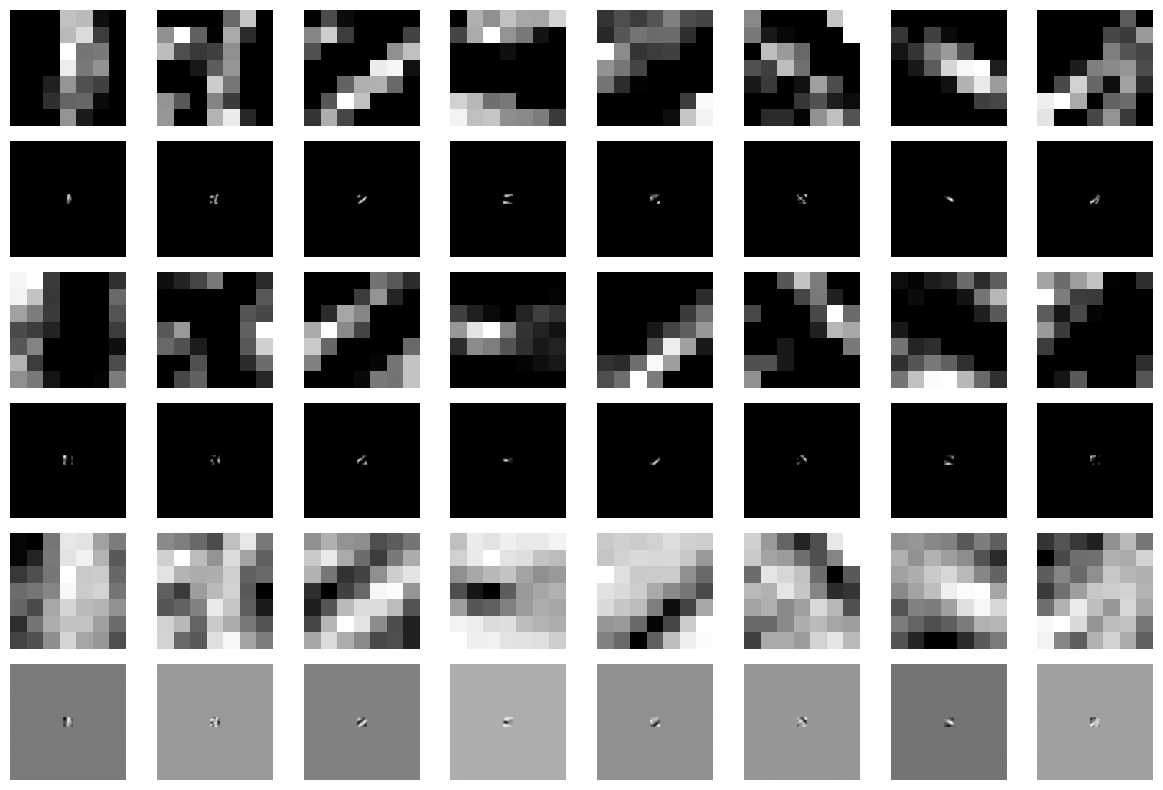

In [2]:
import os
file_path = os.path.abspath("store_outputs/MNIST_7x7_target_psf.pt")
target_psf = torch.load(file_path, map_location="cpu")
file_path2 = os.path.abspath("store_outputs/MNIST_7x7_kernels.pt")
ideal_kernels = torch.load(file_path2, map_location="cpu")

print(target_psf.shape)
print(ideal_kernels.shape)

sys.path.append("initial_phase")
from kernel_to_psf import Kernel2PSF
k2p = Kernel2PSF(config)
raw_kernels = k2p.split_kernels(ideal_kernels.squeeze(1))
print(raw_kernels.shape)

pos, neg = raw_kernels[0::2], raw_kernels[1::2]
ideal = ideal_kernels[:, 0]

tpos, tneg = target_psf[0::2], target_psf[1::2]
tdiff = tpos - tneg

fig, ax = plt.subplots(6, 8, figsize=(12,8))
for k in range(8):
    ax[0,k].imshow(pos[k],   cmap="gray")   # raw pos
    ax[1,k].imshow(tpos[k].T,  cmap="gray", origin="lower")   # target PSF pos
    ax[2,k].imshow(neg[k],   cmap="gray")   # raw neg
    ax[3,k].imshow(tneg[k].T,  cmap="gray", origin="lower")   # target PSF neg
    ax[4,k].imshow(ideal[k], cmap="gray")   # ideal kernel
    ax[5,k].imshow(tdiff[k].T, cmap="gray", origin="lower")   # target PSF diff
    [ax[r,k].axis("off") for r in range(6)]

plt.tight_layout(); plt.show()




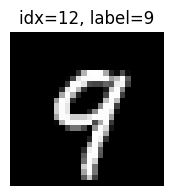

In [3]:
ds = MNIST(root="./data", train=False, download=False, transform=ToTensor())

idx = 12
x, y = ds[idx]                 # x: [1,28,28]
x = x.unsqueeze(0)             # [1,1,28,28]
obj = x

plt.figure(figsize=(2,2))
plt.imshow(x[0,0], cmap="gray", vmin=0, vmax=1)
plt.title(f"idx={idx}, label={y}")
plt.axis("off"); plt.show()

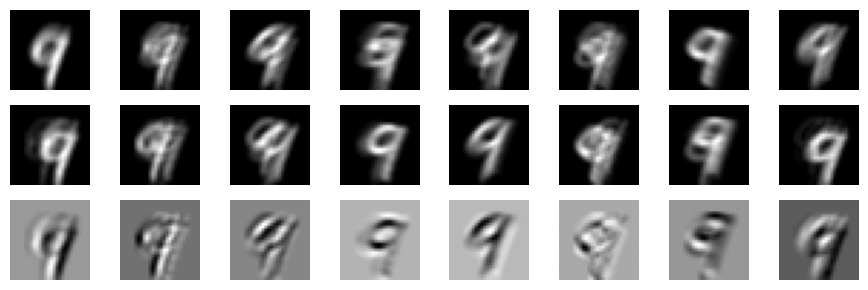

In [4]:
banks = [pos, neg, ideal]
fms = [F.conv2d(x, b.unsqueeze(1), padding="same")[0].detach().cpu() for b in banks]  # each: [8,28,28]

fig, ax = plt.subplots(3, 8, figsize=(9,3))
for r in range(3):
    for k in range(8):
        ax[r,k].imshow(fms[r][k], cmap="gray")
        ax[r,k].axis("off")
plt.tight_layout(); plt.show()



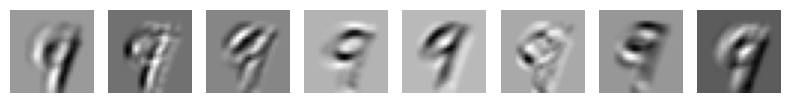

In [5]:
ds = MNIST(root="./data", train=False, download=False, transform=ToTensor())
loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)

all_imgs, all_labels = [], []

with torch.no_grad():
    for x, y in loader:                      # x: [B,1,28,28]
        fm = F.conv2d(x, ideal_kernels, padding="same")  # [B,C,28,28]
        all_imgs.append(fm.cpu())
        all_labels.append(y.cpu())

fm   = torch.cat(all_imgs, dim=0)     # [N,C,28,28]
all_labels = torch.cat(all_labels, dim=0)   # [N]

fig, ax = plt.subplots(1, 8, figsize=(8, 3))
for k in range(8):
    im = ax[k].imshow(fm[12, k], cmap="gray")
    ax[k].axis("off")
# fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
plt.tight_layout(); plt.show()

In [6]:
state = torch.load("store_outputs/MNIST_7x7_fc_final.pt")
W = state["weight"]   # [10, 1152]
b = state["bias"]     # [10]


x = F.relu(fm)
# ---- 2x2 max pool ----
x = F.max_pool2d(x, 2)  # [N,8,12,12]
# ---- flatten ----
x = x.view(x.size(0), -1)  
# ---- linear classifier ----
logits = x @ W.t() + b     # [N,10]
# ---- accuracy ----
preds = logits.argmax(dim=1)
acc = (preds == all_labels).float().mean()

print(f"Classification accuracy: {acc.item()*100:.2f}%")

Classification accuracy: 97.90%


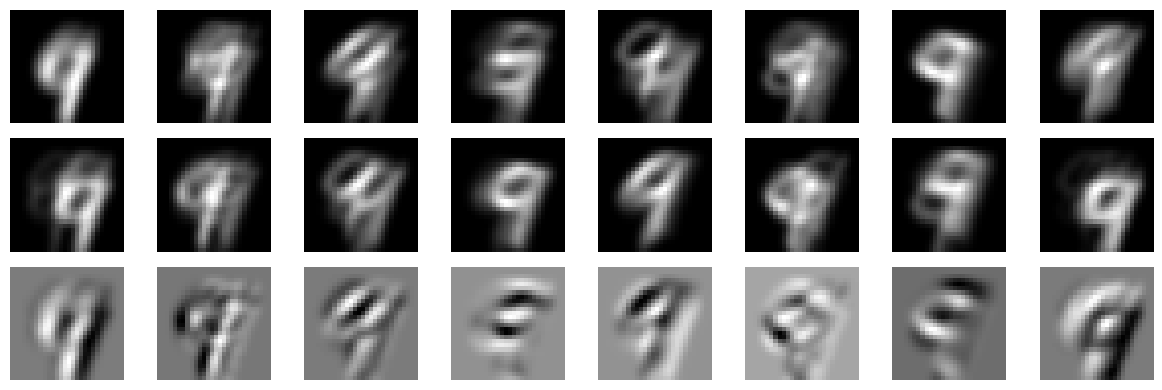

In [7]:
ipos = pp(conv.sensor_image(obj, tpos), subtract=False)      # [8,28,28] (or [1,8,28,28])
ineg = pp(conv.sensor_image(obj, tneg), subtract=False)
idiff = ipos - ineg

# ipos = conv.sensor_image(obj, tpos)
# ineg = conv.sensor_image(obj, tneg)
# idiff = ipos - ineg

# squeeze if pp returns a batch dim
ipos, ineg, idiff = [z.squeeze(0).detach().cpu() for z in (ipos, ineg, idiff)]

fig, ax = plt.subplots(3, 8, figsize=(12,4))
for k in range(8):
    ax[0,k].imshow(ipos[k].T.flip(0).flip(1),  cmap="gray", origin="lower"); ax[0,k].axis("off")
    ax[1,k].imshow(ineg[k].T.flip(0).flip(1),  cmap="gray", origin="lower"); ax[1,k].axis("off")
    ax[2,k].imshow(idiff[k].T.flip(0).flip(1), cmap="gray", origin="lower"); ax[2,k].axis("off")
plt.tight_layout(); plt.show()



In [8]:
ds = MNIST(root="./data", train=False, download=False, transform=ToTensor())
loader = DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)

all_imgs = []
all_labels = []

with torch.no_grad():
    for x, y in loader:                         # x: [B,1,28,28], y: [B]
        imgs = conv.sensor_image(x, target_psf)
        all_imgs.append(pp(imgs, subtract=False).cpu())
        all_labels.append(y.cpu())

all_imgs   = torch.cat(all_imgs, dim=0)   # [N, C, 28, 28]
all_labels = torch.cat(all_labels, dim=0) # [N]

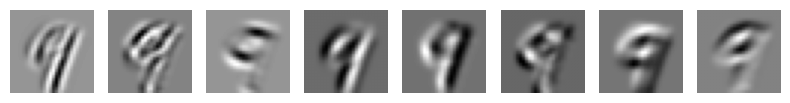

In [9]:

pos = all_imgs[:, 0::2]   # channels 0,2,4,...,14  -> [N, 8, 28, 28]
neg = all_imgs[:, 1::2]   # channels 1,3,5,...,15  -> [N, 8, 28, 28]

feat_maps = pos - neg     # [N, 8, 28, 28]
feat_maps = torch.rot90(feat_maps, k=3, dims=(-2, -1))


fig, ax = plt.subplots(1, 8, figsize=(8, 3))
for k in range(8):
    ax[k].imshow(feat_maps[12, k], cmap="gray")
    ax[k].axis("off")
plt.tight_layout(); plt.show()


In [10]:
state = torch.load("store_outputs/MNIST_7x7_fc_final.pt")
W = state["weight"]   # [10, 1152]
b = state["bias"]     # [10]


# ---- 2x2 max pool ----
x = F.max_pool2d(feat_maps, 2)  # [N,8,12,12]
x = F.relu(x)
# ---- flatten ----
x = x.view(x.size(0), -1)  
# ---- linear classifier ----
logits = x @ W.t() + b     # [N,10]
# ---- accuracy ----
preds = logits.argmax(dim=1)
acc = (preds == all_labels).float().mean()

print(f"Classification accuracy: {acc.item()*100:.2f}%")


Classification accuracy: 94.91%


In [11]:
print(pm.hfov)

8
